In [5]:

#pip install --upgrade psycopg2-binary

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from sqlalchemy import create_engine, text

from pathlib import Path


In [13]:


db_url = "replace this with hosted postgres url"
engine = create_engine(db_url, pool_pre_ping=True)

feedback_df = pd.read_sql_query(text("SELECT * FROM public.feedback"), con=engine)
user_anime_df = pd.read_sql_query(text("SELECT * FROM public.user_anime"), con=engine)

print("feedback columns:",    feedback_df.columns.tolist())
print("user_anime columns:",  user_anime_df.columns.tolist())


feedback columns: ['id', 'anilist_username', 'song_id', 'recommended_by', 'watch_time', 'total_video_time', 'liked', 'timestamp']
user_anime columns: ['id', 'anilist_username', 'mal_id']


In [15]:
feedback_df.head()

,id,anilist_username,song_id,recommended_by,watch_time,total_video_time,liked,timestamp
0,1,anonymousShifu,MkK2W7bAe4k,mpnet,1.598883,90.001,0,2025-04-19 23:15:15.298271
1,2,anonymousShifu,bOO38_bTQbA,minilm,1.622233,116.241,1,2025-04-19 23:15:18.236879
2,3,anonymousShifu,ZRtdQ81jPUQ,popular,168.441014,225.781,0,2025-04-19 23:24:21.603612
3,4,timeTraveller,HYIF0wlVwBI,mpnet,0.000000,122.521,1,2025-04-20 01:13:48.798255
4,5,guest,MkK2W7bAe4k,mpnet,0.000000,0.000,1,2025-04-20 02:35:44.286353


In [17]:

unique_recommenders = feedback_df['recommended_by'].dropna().unique()
print("Unique values in feedback.recommended_by:")
print( unique_recommenders.tolist(), "\n")

unique_feedback_users = feedback_df['anilist_username'].dropna().unique()
print("Unique AniList usernames in feedback.anilist_username:")
print(len(unique_feedback_users.tolist()), "\n")



Unique values in feedback.recommended_by:
['mpnet', 'minilm', 'popular', 'node2vec', 'random', 'tfidf'] 

Unique AniList usernames in feedback.anilist_username:
23 



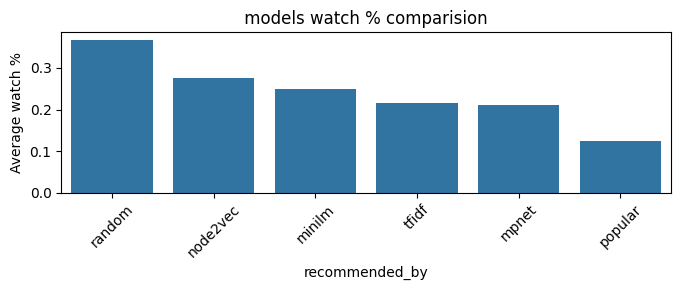

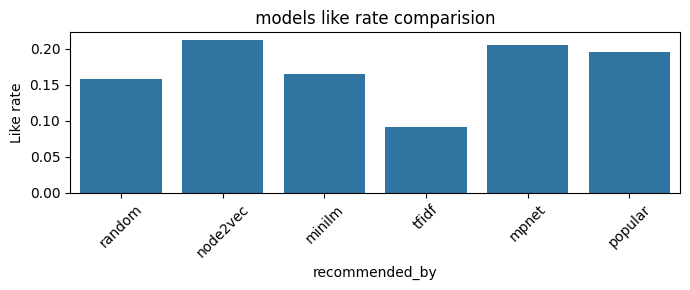

In [1]:


plt.style.use("default")

DB_URL  = "replace this with hosted postgres url"
engine  = create_engine(DB_URL, pool_pre_ping=True)

feedback_df = pd.read_sql_query(text("SELECT * FROM public.feedback"), engine)

fb = feedback_df.copy()
fb = fb[fb.total_video_time > 0]
fb["watch_ratio"] = (fb.watch_time / fb.total_video_time).clip(upper=1.0)

OUT = Path("demo_figs"); OUT.mkdir(exist_ok=True)

snap = (
    fb.groupby("recommended_by")
      .agg(
          impressions = ("id", "size"),
          like_rate   = ("liked", "mean"),
          watch_rate  = ("watch_ratio", "mean")
      )
      .sort_values("watch_rate", ascending=False)
      .round(3)
)

plt.figure(figsize=(7,3))
sns.barplot(x=snap.index, y=snap.watch_rate)
plt.ylabel("Average watch %"); plt.title(" models watch % comparision ")
plt.xticks(rotation=45); plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(x=snap.index, y=snap.like_rate)
plt.ylabel("Like rate"); plt.title(" models like rate comparision ")
plt.xticks(rotation=45); plt.tight_layout()
plt.show()


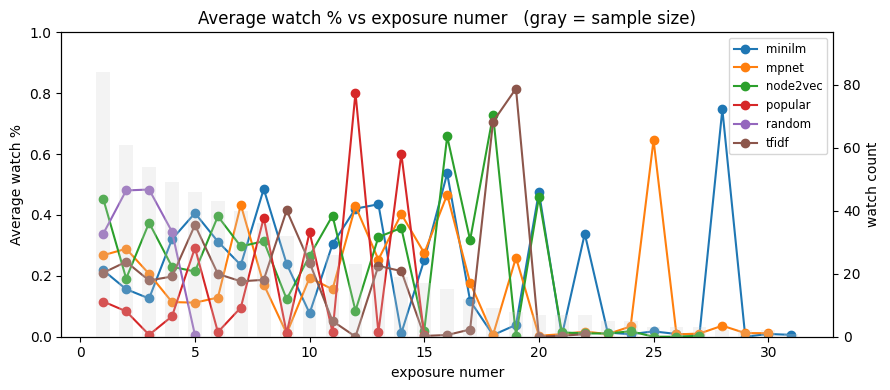

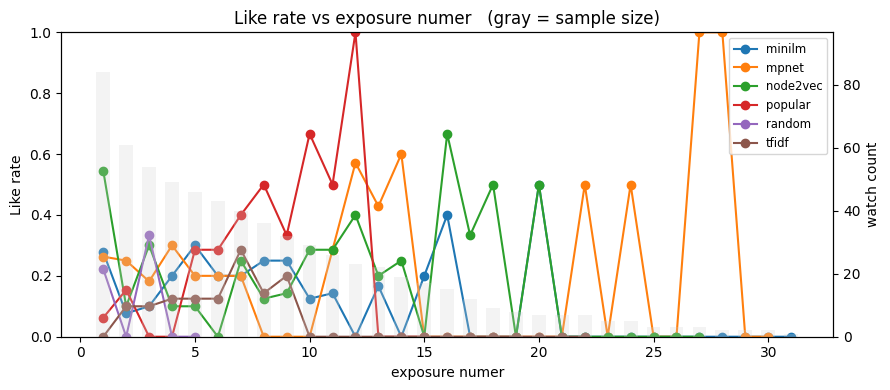

In [5]:



fb = feedback_df.copy()
fb = fb[fb.total_video_time>0]
fb["watch_ratio"] = (fb.watch_time/fb.total_video_time).clip(upper=1)
fb = fb.sort_values("timestamp")
fb["seq"] = fb.groupby(["anilist_username","recommended_by"]).cumcount()+1

engage = (
    fb.groupby(["recommended_by","seq"])
       .agg(
           watch_ratio = ("watch_ratio","mean"),
           like_rate   = ("liked","mean"),
           users       = ("anilist_username","nunique")
       )
       .reset_index()
)

def plot_metric(metric, ylabel):
    plt.figure(figsize=(9,4))
    ax1 = plt.gca()

    for m,d in engage.groupby("recommended_by"):
        ax1.plot(d["seq"], d[metric], marker="o", label=m)
    ax1.set_xlabel("exposure numer")
    ax1.set_ylabel(ylabel)
    ax1.set_ylim(0,1)
    
    ax2 = ax1.twinx()
    totals = engage.groupby("seq").users.sum()
    ax2.bar(totals.index, totals.values, color="lightgray", alpha=0.25,
            width=0.6, label="# users")
    ax2.set_ylabel("watch count")
    ax2.set_ylim(0, totals.max()*1.15)

    ax1.set_title(f"{ylabel} vs exposure numer   (gray = sample size)")
    ax1.legend(loc="upper right", fontsize="small")
    plt.tight_layout(); 
    plt.show()

plot_metric("watch_ratio", "Average watch %")
plot_metric("like_rate",   "Like rate")


In [9]:


OUT = Path("demo_figs_permodel"); OUT.mkdir(exist_ok=True)

engage = (
    fb.groupby(["recommended_by","seq"])
       .agg(
           watch_ratio = ("watch_ratio","mean"),
           like_rate   = ("liked","mean"),
           users       = ("anilist_username","nunique")
       )
       .reset_index()
)
# for this we dont print but instead save png
def make_per_model_plots(metric, ylabel, suffix):
    for model, d in engage.groupby("recommended_by"):
        plt.figure(figsize=(8,4))

        plt.plot(d["seq"], d[metric], marker="o", color="tab:blue")
        plt.xlabel("Exposure #")
        plt.ylabel(ylabel, color="tab:blue")
        plt.ylim(0,1)
        ax2 = plt.gca().twinx()
        ax2.bar(d["seq"], d["users"], color="lightgray", alpha=0.35,
                width=0.6)
        ax2.set_ylabel("User count", color="gray")
        ax2.set_ylim(0, d["users"].max()*1.15)

        plt.title(f"{model} — {ylabel} vs exposure #")
        plt.tight_layout()
        fname = f"{model}_{suffix}.png"
        plt.savefig(OUT/fname); plt.close()
        plt.show()
        print("saved", fname)

make_per_model_plots("watch_ratio", "Average watch %", "watch_seq")
make_per_model_plots("like_rate",   "Like rate",       "like_seq")


saved minilm_watch_seq.png
saved mpnet_watch_seq.png
saved node2vec_watch_seq.png
saved popular_watch_seq.png
saved random_watch_seq.png
saved tfidf_watch_seq.png
saved minilm_like_seq.png
saved mpnet_like_seq.png
saved node2vec_like_seq.png
saved popular_like_seq.png
saved random_like_seq.png
saved tfidf_like_seq.png
